# Shelter Animal Outcome #

A lot can be done in terms of feature engineering in this project and I have only explored a few. Here are some more ideas:

- Breed can be further explored by having more features. The 'breed2' of 'breed1/breed2' mix can be retained as opposed to being discarded. The same applies to Color. Perhaps hair length can also be an important feature (longer hair are more desirable?) which can be deducted from Breed. 
- DateTime could also be a useful feature which was not used here. 

Missing ages are filled using Random Forest Regressor whereas the actual multi-class prediction was done using Random Forest Classifier.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

from plot_learning_curve import plot_learning_curve

In [2]:
df_train = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)

In [4]:
df_train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
df_test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


First glance at these data we know that Breed and Color definetely need some feature engineering.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 1.0+ MB


## Exploratory Data Analysis ##

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


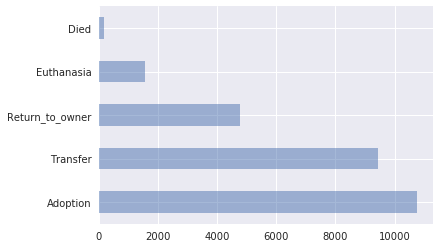

In [6]:
df_train.OutcomeType.value_counts().plot(kind='barh', alpha=0.5)

Multi classification problem.

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


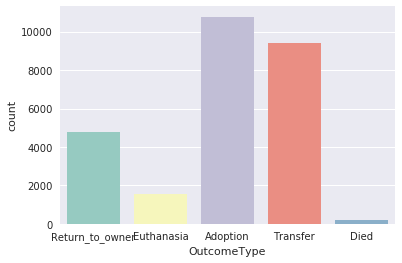

In [7]:
sns.countplot(df_train.OutcomeType, palette='Set3')

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


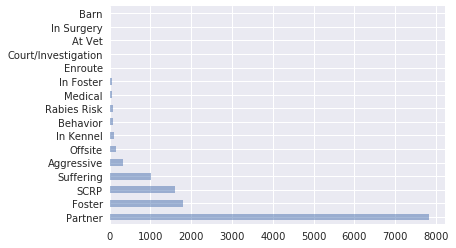

In [8]:
df_train.OutcomeSubtype.value_counts().plot(kind='barh', alpha=0.5)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


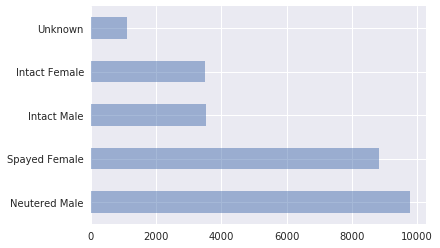

In [9]:
df_train.SexuponOutcome.value_counts().plot(kind='barh', alpha=0.5)

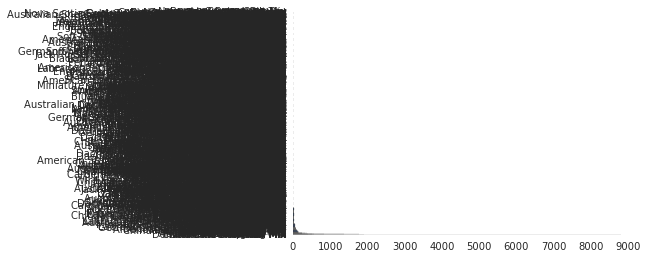

In [9]:
df_train.Breed.value_counts().plot(kind='barh', alpha=0.5)

In [4]:
len(df_train.Breed.unique())

1380

Way too many Breed. Need to do something about this.

In [10]:
(df_train.Breed.value_counts() < 2).value_counts()

False    701
True     679
Name: Breed, dtype: int64

Almost half of the animals are in its own Breed category.

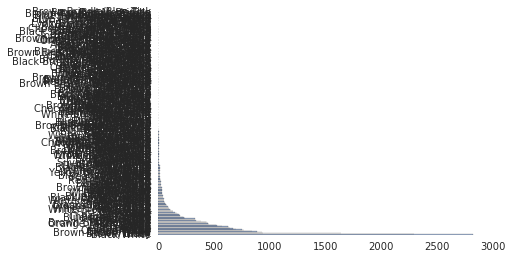

In [11]:
df_train.Color.value_counts().plot(kind='barh', alpha=0.5)

In [5]:
len(df_train.Color.unique())

366

In [12]:
(df_train.Color.value_counts() < 2).value_counts()

False    247
True     119
Name: Color, dtype: int64

Again, a lot of colours. Need to do something about it.

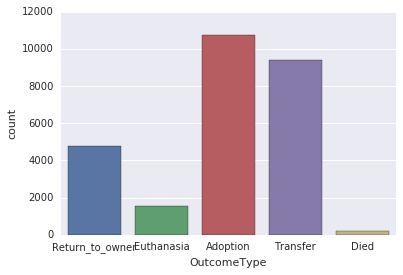

In [6]:
sns.countplot(x="OutcomeType",data=df_train_cp)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


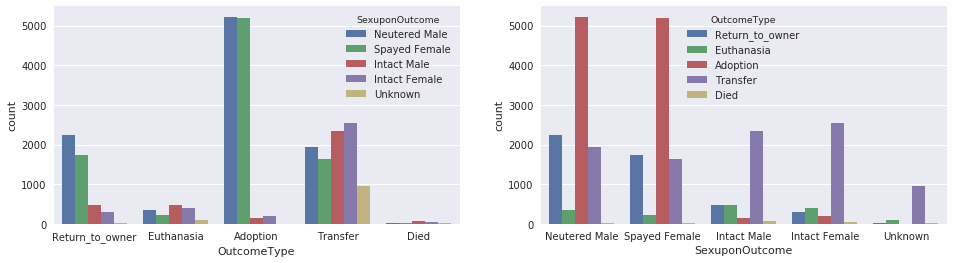

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=df_train, x='OutcomeType',hue='SexuponOutcome', ax=ax1)
sns.countplot(data=df_train, x='SexuponOutcome',hue='OutcomeType', ax=ax2)

Neutered Male and Spayed Female are more likely to get adopted.

## Feature Engineering ##

In [3]:
# rename AnimalID column

df_test.rename(columns = {'ID':'AnimalID'}, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11456 entries, 0 to 11455
Data columns (total 8 columns):
AnimalID          11456 non-null int64
Name              8231 non-null object
DateTime          11456 non-null object
AnimalType        11456 non-null object
SexuponOutcome    11456 non-null object
AgeuponOutcome    11450 non-null object
Breed             11456 non-null object
Color             11456 non-null object
dtypes: int64(1), object(7)
memory usage: 716.1+ KB


Fist, 'Sex' can be broken into 'Sex' ('Male', 'Female', 'Unknown') and Intact ('True', 'False', 'Unknown')

In [5]:
all_df = pd.concat([df_train, df_test] ,keys = ['train', 'test'])
all_df['Sex'] = all_df.SexuponOutcome.str.split().str[1]

all_df['Sex'].head()

train  0      Male
       1    Female
       2      Male
       3      Male
       4      Male
Name: Sex, dtype: object

In [26]:
all_df['Intact'] = 'False'
all_df.loc[all_df.SexuponOutcome.str.split().str[0] == 'Intact', 'Intact'] = 'True'

all_df['Intact'].head()

train  0    False
       1    False
       2    False
       3     True
       4    False
Name: Intact, dtype: object

In [7]:
all_df.loc[all_df.SexuponOutcome == 'Unknown', ['Sex', 'Intact']] = 'Unknown'
all_df.loc[all_df.SexuponOutcome.isnull(), ['Sex', 'Intact']] = 'Unknown'

Next, Breed transformation. We add Mix Boolean feature first.

In [17]:
all_df['Mix'] = False
all_df.loc[all_df['Breed'].str.split().str[-1] == 'Mix', 'Mix'] = True

all_df.Mix.head()

train  0     True
       1     True
       2     True
       3     True
       4    False
Name: Mix, dtype: bool

In [18]:
len(all_df[all_df.Mix == True])

31871

In [19]:
len(all_df[all_df.Mix == False])

6314

We remove the word 'Mix' and generate a new list of breeds. However, this list is not complete. There are still some breeds named 'Breed1/Breed2'.

In [21]:
all_df['SimpleBreed'] = all_df['Breed'].str.replace(' Mix', '')

len(all_df.SimpleBreed.unique())

1527

In [22]:
all_df[all_df.SimpleBreed.str.contains(r'/[\w ]*/')]

AgeuponOutcome AnimalID AnimalType  \
train 4048        7 months  A669926        Dog   
      6720        2 months  A695953        Dog   
      8213          1 year  A690356        Dog   
      9677        6 months  A664780        Dog   
      10488       5 months  A691448        Dog   
      14956       6 months  A664782        Dog   
      17332       6 months  A664781        Dog   
      18126       4 months  A691447        Dog   
      19667       6 months  A664779        Dog   
      20341       8 months  A668745        Dog   
test  4889         2 years      NaN        Dog   
      8168         3 years      NaN        Dog   
      10555       5 months      NaN        Dog   
      10697       6 months      NaN        Dog   

                                          Breed        Color  \
train 4048          Plott Hound/Black/Tan Hound    Brown/Tan   
      6720   Labrador Retriever/Black/Tan Hound        Black   
      8213      German Shepherd/Black/Tan Hound    Black/Tan   
      9677   Labrador Retriever/Black/Tan Hound        Black   
      10488     Black/Tan Hound/Black Mouth Cur     Tricolor   
      14956  Labrador Retriever/Black/Tan Hound       Yellow   
      17332  Labrador Retriever/Black/Tan Hound  Black/White   
      18126     Black/Tan Hound/Black Mouth Cur        Brown   
      19667  Black/Tan Hound/Labrador Retriever    Black/Tan   
      20341     Black/Tan Hound/German Shepherd    Black/Tan   
test  4889      German Shepherd/Black/Tan Hound    Black/Tan   
      8168       Black/Tan Hound/Siberian Husky    Black/Tan   
      10555     German Shepherd/Black/Tan Hound  Brown/Black   
      10697  Labrador Retriever/Black/Tan Hound         Fawn   

                        DateTime       ID       Name OutcomeSubtype  \
train 4048   2014-01-01 13:00:00      NaN        NaN        Partner   
      6720   2015-01-31 11:08:00      NaN        NaN        Partner   
      8213   2014-10-25 12:23:00      NaN     Cooper            NaN   
      9677   2013-10-21 11:20:00      NaN       Jade            NaN   
      10488  2014-11-30 11:32:00      NaN  Sylvester        Partner   
      14956  2013-10-16 17:05:00      NaN    Lucille        Partner   
      17332  2013-11-01 18:19:00      NaN     Truman            NaN   
      18126  2014-11-08 16:14:00      NaN      Wyatt        Partner   
      19667  2013-10-16 17:05:00      NaN      Lacey        Partner   
      20341  2013-12-19 15:05:00      NaN     Parker        Partner   
test  4889   2013-12-23 11:08:00   4890.0      Woody            NaN   
      8168   2015-02-23 18:31:00   8169.0        Sam            NaN   
      10555  2015-08-22 17:52:00  10556.0     Wesley            NaN   
      10697  2013-10-20 15:36:00  10698.0     Leland            NaN   

            OutcomeType SexuponOutcome     Sex Intact    Mix  \
train 4048     Transfer  Intact Female  Female   True  False   
      6720     Transfer  Neutered Male    Male  False  False   
      8213     Adoption  Neutered Male    Male  False  False   
      9677     Adoption  Spayed Female  Female  False  False   
      10488    Transfer  Neutered Male    Male  False  False   
      14956    Transfer  Intact Female  Female   True  False   
      17332    Adoption  Neutered Male    Male  False  False   
      18126    Transfer    Intact Male    Male   True  False   
      19667    Transfer  Intact Female  Female   True  False   
      20341    Transfer  Neutered Male    Male  False  False   
test  4889          NaN  Neutered Male    Male  False  False   
      8168          NaN  Intact Female  Female   True  False   
      10555         NaN  Neutered Male    Male  False  False   
      10697         NaN  Neutered Male    Male  False  False   

                                    SimpleBreed  
train 4048          Plott Hound/Black/Tan Hound  
      6720   Labrador Retriever/Black/Tan Hound  
      8213      German Shepherd/Black/Tan Hound  
      9677   Labrador Retriever/Black/Tan Hound  
      10488     Black/T

Black/Tan Hound is in fact a breed type so we cannot use '/' for regex. Let's rename it to something else.

In [11]:
all_df.SimpleBreed = all_df.SimpleBreed.str.replace('Black/Tan', 'BlacknTan')

Before we go further, let's check if there are cases such that 'Breed1' and 'Breed2' appear together but in different order.

In [15]:
breedtypes = df_train[~df_train.SimpleBreed.str.contains('/')].SimpleBreed.unique()

len(breedtypes)

217

In [84]:
temp_df = df_train[df_train.SimpleBreed.str.contains('/')]
print("{} contains '/' and {} are unique".format(len(temp_df), len(temp_df.SimpleBreed.unique())))

3037 contains / and 1027 are unique


Sort the 'breed1/breed2' combination and check unique again

In [13]:
df_train.SimpleBreed = df_train.SimpleBreed.str.split('/').apply(np.sort)

df_train.SimpleBreed = df_train.SimpleBreed.apply(lambda x: '/'.join(x))

len(df_train.SimpleBreed.unique())

1007

So the order in 'Breed1/Breed2' does make a small difference. However, is this cause by data entry preference which is insignificant or one breed type is more dominating than the other?

Find out how many 'Breed1' of 'Breed1/Breed2' are in the the breedtypes

In [16]:
len(temp_df[temp_df.SimpleBreed.str.split('/').str[0].isin(breedtypes)])

2933


What about not in the breedtypes?

In [177]:
len(temp_df[~temp_df.SimpleBreed.str.split('/').str[0].isin(breedtypes)])

104

In [179]:
# unique breeds
len(temp_df[~temp_df.SimpleBreed.str.split('/').str[0].isin(breedtypes)].SimpleBreed.str.split('/').str[0].unique())

30

'Breed2' of 'Breed1/Breed2' not in the breedtypes?

In [25]:
len(temp_df[~temp_df.SimpleBreed.str.split('/').str[1].isin(breedtypes)])

97

How many Breed are not in breedtypes?

In [197]:
newbreed1 = temp_df[~temp_df.SimpleBreed.str.split('/').str[0].isin(breedtypes)].SimpleBreed.str.split('/').str[0].unique()
newbreed2 = temp_df[~temp_df.SimpleBreed.str.split('/').str[1].isin(breedtypes)].SimpleBreed.str.split('/').str[1].unique()

newbreed = [x for x in newbreed1 if x not in newbreed2] + [x for x in newbreed2 if x not in newbreed1]
print('{} more new types'.format(len(newbreed)))
print(newbreed)

27 more new types
['Kuvasz', 'Norwich Terrier', 'Irish Setter', 'Irish Terrier', 'Boykin Span', 'Tibetan Terrier', 'English Coonhound', 'Chinese Crested', 'Patterdale Terr', 'Glen Of Imaal', 'Belgian Tervuren', 'Irish Wolfhound', 'Swiss Hound', 'Silky Terrier', 'English Cocker Spaniel', 'English Setter', 'Yorkshire', 'Schnauzer Giant', 'Welsh Terrier', 'Rex', 'Affenpinscher', 'Japanese Bobtail', 'Spanish Water Dog', 'Unknown', 'Smooth Fox Terrier', 'Borzoi', 'Neapolitan Mastiff']


So far I don't know the best way to include both breed information in 'Breed1/Breed2'. Making two features is not a good idea because which breed type should be included in feature1 but not the other? 

I decided to simply drop the second breed for now.

In [25]:
all_df.loc[all_df.SimpleBreed.str.contains('/'), 'Mix'] = True

len(all_df[all_df.Mix == True])

36195

In [31]:
all_df['SimpleBreed1'] = all_df.SimpleBreed.str.replace(r'/[\w ]*', '')

len(all_df.SimpleBreed1.unique())

234

A lot better than 1380. Now deal with the Color. Let's make it into 'Color' and 'Pattern'.

In [34]:
len(all_df.Color.unique())

411

In [48]:
len(all_df[all_df.Color.str.contains(' Tabby')])

7404

In [15]:
all_df['Pattern'] = False
all_df.loc[all_df.Color.str.contains(' Tabby'), 'Pattern'] = True

all_df['SimpleColor'] = all_df.Color.str.replace(' Tabby', '')

In [60]:
all_df[(all_df.AnimalType == 'Dog') & (all_df.Pattern == True)]

,,AgeuponOutcome,AnimalID,AnimalType,Breed,Color,DateTime,ID,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,Sex,Intact,Mix,SimpleBreed,SimpleBreed1,Pattern,SimpleColor
train,4998,10 months,A716075,Dog,Jack Russell Terrier/Basenji,White/Brown Tabby,2015-11-17 17:23:00,NaN,Toby,NaN,Return_to_owner,Neutered Male,Male,False,True,Jack Russell Terrier/Basenji,Jack Russell Terrier,True,White/Brown


Interesting to see one dog with Tabby pattern.

Same again. We strip the second color.

In [16]:
all_df['SimpleColor1'] = all_df.SimpleColor.str.replace(r'[/ ]+[\w ]*', '')

Do something similar to name

In [17]:
all_df['HasName'] = True
all_df.loc[all_df.Name.isnull(), 'HasName'] = False

all_df.head()

AgeuponOutcome AnimalID AnimalType                        Breed  \
train 0         1 year  A671945        Dog        Shetland Sheepdog Mix   
      1         1 year  A656520        Cat       Domestic Shorthair Mix   
      2        2 years  A686464        Dog                 Pit Bull Mix   
      3        3 weeks  A683430        Cat       Domestic Shorthair Mix   
      4        2 years  A667013        Dog  Lhasa Apso/Miniature Poodle   

               Color             DateTime     Name OutcomeSubtype  \
train 0  Brown/White  2014-02-12 18:22:00  Hambone            NaN   
      1  Cream Tabby  2013-10-13 12:44:00    Emily      Suffering   
      2   Blue/White  2015-01-31 12:28:00   Pearce         Foster   
      3   Blue Cream  2014-07-11 19:09:00      NaN        Partner   
      4          Tan  2013-11-15 12:52:00      NaN        Partner   

             OutcomeType SexuponOutcome     Sex Intact   Mix  \
train 0  Return_to_owner  Neutered Male    Male  False  True   
      1       Euthanasia  Spayed Female  Female  False  True   
      2         Adoption  Neutered Male    Male  False  True   
      3         Transfer    Intact Male    Male   True  True   
      4         Transfer  Neutered Male    Male  False  True   

                         SimpleBreed        SimpleBreed1 Pattern  SimpleColor  \
train 0            Shetland Sheepdog   Shetland Sheepdog   False  Brown/White   
      1           Domestic Shorthair  Domestic Shorthair    True        Cream   
      2                     Pit Bull            Pit Bull   False   Blue/White   
      3           Domestic Shorthair  Domestic Shorthair   False   Blue Cream   
      4  Lhasa Apso/Miniature Poodle          Lhasa Apso   False          Tan   

        SimpleColor1 HasName  
train 0        Brown    True  
      1        Cream    True  
      2         Blue    True  
      3         Blue   False  
      4          Tan   False

Transform AgeuponOutcome

In [54]:
len(all_df[all_df.AgeuponOutcome.isnull()])

24

Many missing values. Need to fill them up with RandomForest later.

In [18]:
def age_in_days(age):
    value = age.split(' ')[0]
    unit = age.split(' ')[1]
    if (unit == 'year') | (unit == 'years'):
        value = float(value) * 365.25
    elif (unit == 'month') | (unit == 'months'):
        value = float(value) * 30.4375
    elif (unit == 'week') | (unit == 'weeks'):
        value = float(value) * 7
    #if (len(age) > 6):
        #print(age)
    return value

In [19]:
# Convert series to array of floats
all_df['AgeinDays'] = pd.to_numeric(all_df.loc[pd.notnull(all_df.AgeuponOutcome), 'AgeuponOutcome'].map(lambda x: age_in_days(x)))

In [20]:
new_df = all_df.copy()

In [21]:
# Encode the train set classes first
le_OutcomeType = LabelEncoder()
le_SimpleBreed1 = LabelEncoder()
le_SimpleColor1 = LabelEncoder()
le_Sex = LabelEncoder()
le_Intact = LabelEncoder()
le_Mix = LabelEncoder()
le_Pattern = LabelEncoder()
le_HasName = LabelEncoder()

le_OutcomeType.fit(all_df.loc['train', 'OutcomeType'])
le_SimpleBreed1.fit(all_df.SimpleBreed1)
le_SimpleColor1.fit(all_df.SimpleColor1)
le_Sex.fit(all_df.Sex)
le_Intact.fit(all_df.Intact)
le_Mix.fit(all_df.Mix)
le_Pattern.fit(all_df.Pattern)
le_HasName.fit(all_df.HasName)

new_df.loc['train', 'OutcomeType'] = le_OutcomeType.transform(all_df.loc['train', 'OutcomeType'])
new_df.SimpleBreed1 = le_SimpleBreed1.transform(all_df.SimpleBreed1)
new_df.SimpleColor1 = le_SimpleColor1.transform(all_df.SimpleColor1)
new_df.Sex = le_Sex.transform(all_df.Sex)
new_df.Intact = le_Intact.transform(all_df.Intact)
new_df.Mix = le_Mix.transform(all_df.Mix)
new_df.Pattern = le_Pattern.transform(all_df.Pattern)
new_df.HasName = le_HasName.transform(all_df.HasName)

In [23]:
new_df.head()

AgeuponOutcome AnimalID AnimalType                        Breed  \
train 0         1 year  A671945        Dog        Shetland Sheepdog Mix   
      1         1 year  A656520        Cat       Domestic Shorthair Mix   
      2        2 years  A686464        Dog                 Pit Bull Mix   
      3        3 weeks  A683430        Cat       Domestic Shorthair Mix   
      4        2 years  A667013        Dog  Lhasa Apso/Miniature Poodle   

               Color             DateTime     Name OutcomeSubtype OutcomeType  \
train 0  Brown/White  2014-02-12 18:22:00  Hambone            NaN           3   
      1  Cream Tabby  2013-10-13 12:44:00    Emily      Suffering           2   
      2   Blue/White  2015-01-31 12:28:00   Pearce         Foster           0   
      3   Blue Cream  2014-07-11 19:09:00      NaN        Partner           4   
      4          Tan  2013-11-15 12:52:00      NaN        Partner           4   

        SexuponOutcome  Sex  Intact  Mix                  SimpleBreed  \
train 0  Neutered Male    1       0    1            Shetland Sheepdog   
      1  Spayed Female    0       0    1           Domestic Shorthair   
      2  Neutered Male    1       0    1                     Pit Bull   
      3    Intact Male    1       1    1           Domestic Shorthair   
      4  Neutered Male    1       0    1  Lhasa Apso/Miniature Poodle   

         SimpleBreed1  Pattern  SimpleColor  SimpleColor1  HasName  AgeinDays  
train 0           194        0  Brown/White             4        1     365.25  
      1            85        1        Cream             8        1     365.25  
      2           170        0   Blue/White             3        1     730.50  
      3            85        0   Blue Cream             3        0      21.00  
      4           136        0          Tan            23        0     730.50

In [22]:
le_OutcomeType.fit(all_df.loc['train', 'OutcomeType'])
le_SimpleBreed1.fit(all_df.SimpleBreed1)
le_SimpleColor1.fit(all_df.SimpleColor1)
le_Sex.fit(all_df.Sex)
le_Intact.fit(all_df.Intact)
le_Mix.fit(all_df.Mix)
le_Pattern.fit(all_df.Pattern)
le_HasName.fit(all_df.HasName)

LabelEncoder()

It is obvious that cats and dogs should use different models.

Making Age model (for cats)

In [23]:
features = new_df.loc[pd.notnull(new_df.AgeinDays) & (new_df.AnimalType == 'Cat'), ['SimpleBreed1', 'SimpleColor1', 'Sex', 'Intact', 'Mix', 'Pattern', 'HasName']]
target = new_df.loc[pd.notnull(new_df.AgeinDays) & (new_df.AnimalType == 'Cat'), 'AgeinDays']

In [24]:
parameters = {'max_features':('sqrt', 'log2', 'auto'), 'min_samples_split': list(range(2,15)), 'min_samples_leaf': list(range(1,10))}

GSCV = GridSearchCV(RandomForestRegressor(random_state = 1, n_jobs=-1), parameters, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose = 0)
GSCV.fit(features, target)

print('Best Score')
print(GSCV.best_score_)
print('Best Params')
print(GSCV.best_params_)

Best Score
-824753.895686
Best Params
{'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


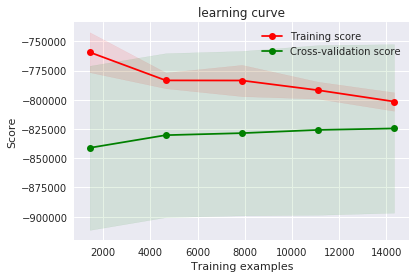

In [24]:
plot_learning_curve(RandomForestRegressor(n_estimators = 100, random_state = 1, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 8), 
                    title = 'learning curve', X = features, y = target, cv = 10, scoring = 'neg_mean_squared_error', verbose = 0)

In [25]:
model = RandomForestRegressor(n_estimators = 100, random_state = 1, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 8)
model.fit(features, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [26]:
X_test = new_df.loc[new_df.AgeinDays.isnull() & (new_df.AnimalType == 'Cat'), ['SimpleBreed1', 'SimpleColor1', 'Sex', 'Intact', 'Mix', 'Pattern', 'HasName']]

In [27]:
y_pred = model.predict(X_test)
new_df.loc[new_df.AgeinDays.isnull() & (new_df.AnimalType == 'Cat'), 'AgeinDays'] = y_pred

Making Age model (for Dogs)

In [28]:
features = new_df.loc[pd.notnull(new_df.AgeinDays) & (new_df.AnimalType == 'Dog'), ['SimpleBreed1', 'SimpleColor1', 'Sex', 'Intact', 'Mix', 'Pattern', 'HasName']]
target = new_df.loc[pd.notnull(new_df.AgeinDays) & (new_df.AnimalType == 'Dog'), 'AgeinDays']

In [29]:
parameters = {'max_features':('sqrt', 'log2', 'auto'), 'min_samples_split': list(range(2,15)), 'min_samples_leaf': list(range(1,10))}

GSCV = GridSearchCV(RandomForestRegressor(random_state = 1, n_jobs=-1), parameters, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose = 0)
GSCV.fit(features, target)

print('Best Score')
print(GSCV.best_score_)
print('Best Params')
print(GSCV.best_params_)

Best Score
-1163100.222
Best Params
{'min_samples_split': 2, 'max_features': 'sqrt', 'min_samples_leaf': 9}


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


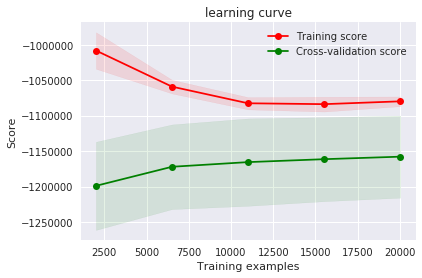

In [30]:
plot_learning_curve(RandomForestRegressor(n_estimators = 100, random_state = 1, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 8), 
                    title = 'learning curve', X = features, y = target, cv = 10, scoring = 'neg_mean_squared_error', verbose = 0)

In [31]:
model = RandomForestRegressor(n_estimators = 100, random_state = 1, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 8)
model.fit(features, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [32]:
X_test = new_df.loc[new_df.AgeinDays.isnull() & (new_df.AnimalType == 'Dog'), ['SimpleBreed1', 'SimpleColor1', 'Sex', 'Intact', 'Mix', 'Pattern', 'HasName']]

In [33]:
y_pred = model.predict(X_test)
new_df.loc[new_df.AgeinDays.isnull() & (new_df.AnimalType == 'Dog'), 'AgeinDays'] = y_pred

## Machine Learning ##

First for cats

In [35]:
mask = new_df['AnimalType'] == 'Cat'

features = new_df.loc[pd.IndexSlice[['train'], mask], ['SimpleBreed1', 'SimpleColor1', 'Sex', 'Intact', 'Mix', 'Pattern', 'HasName', 'AgeinDays']]
target = list(new_df.loc[pd.IndexSlice[['train'], mask], 'OutcomeType'].values)

In [36]:
parameters = {'max_features':('sqrt', 'log2', 'auto'), 'min_samples_split': list(range(2,15)), 'min_samples_leaf': list(range(1,10))}

GSCV = GridSearchCV(RandomForestClassifier(random_state = 1, n_jobs=-1), parameters, cv=10, scoring='neg_log_loss', n_jobs=-1, verbose=0)
GSCV.fit(features, target)

print('Best Score')
print(GSCV.best_score_)
print('Best Params')
print(GSCV.best_params_)

Best Score
-0.683040438668
Best Params
{'min_samples_split': 2, 'max_features': 'sqrt', 'min_samples_leaf': 9}


In [38]:
model = RandomForestClassifier(n_estimators = 100, random_state = 1, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 9)
model.fit(features, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=9,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [39]:
model.feature_importances_

array([ 0.01337512,  0.0208259 ,  0.03808782,  0.44042717,  0.00087185,
        0.00416693,  0.15205151,  0.3301937 ])

In [40]:
mask = new_df['AnimalType'] == 'Cat'

X_test = new_df.loc[pd.IndexSlice[['test'], mask], ['SimpleBreed1', 'SimpleColor1', 'Sex', 'Intact', 'Mix', 'Pattern', 'HasName', 'AgeinDays']]

In [42]:
y_pred_cat = model.predict_proba(X_test)

y_df = pd.DataFrame(data=y_pred_cat, index=X_test.index)

Now for the dogs

In [43]:
mask = new_df['AnimalType'] == 'Dog'

features = new_df.loc[pd.IndexSlice[['train'], mask], ['SimpleBreed1', 'SimpleColor1', 'Sex', 'Intact', 'Mix', 'Pattern', 'HasName', 'AgeinDays']]
target = list(new_df.loc[pd.IndexSlice[['train'], mask], 'OutcomeType'].values)

In [44]:
parameters = {'max_features':('sqrt', 'log2', 'auto'), 'min_samples_split': list(range(2,15)), 'min_samples_leaf': list(range(1,10))}

GSCV = GridSearchCV(RandomForestClassifier(random_state = 1, n_jobs=-1), parameters, cv=10, scoring='neg_log_loss', n_jobs=-1, verbose=0)
GSCV.fit(features, target)

print('Best Score')
print(GSCV.best_score_)
print('Best Params')
print(GSCV.best_params_)

Best Score
-1.0319587275
Best Params
{'min_samples_split': 2, 'max_features': 'sqrt', 'min_samples_leaf': 9}


In [47]:
model = RandomForestClassifier(n_estimators = 100, random_state = 1, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 9)
model.fit(features, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=9,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [48]:
model.feature_importances_

array([ 0.14577304,  0.07649413,  0.0210664 ,  0.33433831,  0.01357419,
        0.        ,  0.09528268,  0.31347124])

In [49]:
mask = new_df['AnimalType'] == 'Dog'

X_test = new_df.loc[pd.IndexSlice[['test'], mask], ['SimpleBreed1', 'SimpleColor1', 'Sex', 'Intact', 'Mix', 'Pattern', 'HasName', 'AgeinDays']]

In [54]:
y_pred_dog = model.predict_proba(X_test)

y_df_dog = pd.DataFrame(data=y_pred_dog, index=X_test.index)

In [55]:
y_df_final = y_df.append(y_df_dog)
y_df_final.sort_index(inplace=True)
y_df_final = y_df_final.reset_index(drop=True)

In [60]:
y_df_final.insert(0, 'ID', df_test.AnimalID)
y_df_final.rename(columns = {0:'Adoption'}, inplace=True)
y_df_final.rename(columns = {1:'Died'}, inplace=True)
y_df_final.rename(columns = {2:'Euthanasia'}, inplace=True)
y_df_final.rename(columns = {3:'Return_to_owner'}, inplace=True)
y_df_final.rename(columns = {4:'Transfer'}, inplace=True)
y_df_final.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1.0,0.103366,0.001572,0.046163,0.251350,0.597548
1,2.0,0.103366,0.001572,0.046163,0.251350,0.597548
2,3.0,0.395876,0.015644,0.038071,0.299283,0.251126
3,4.0,0.395876,0.015644,0.038071,0.299283,0.251126
4,5.0,0.122484,0.004445,0.049123,0.132563,0.691386


In [61]:
y_df_final.to_csv('submission.csv', index=False)